In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt

# Ridge Regression implementation

### Custom Ridge Regressor (normal equation implementation)

$w = (X^{T}X + \alpha I)^{-1}X^{T}y$

In [2]:
class RidgeRegNormalEquation():
    
    def __init__(self, alpha=1.0):
        if alpha < 0:
            raise ValueError('Parameter alpha must be non-negative')
        self.alpha = alpha
        
    def fit(self, X, y):
        X_extended = np.c_[np.ones((X.shape[0], 1)), X]
        
        I = np.eye(X_extended.shape[1])
        I[0, 0] = 0
        I_ridge = self.alpha * I 
        
        w = np.linalg.inv(X_extended.T.dot(X_extended) + I_ridge).dot(X_extended.T).dot(y)
        self.w = w
        return self
        
    def predict(self, X):
        X_pred = np.c_[np.ones((X.shape[0], 1)), X]
        return X_pred.dot(self.w)

### Custom Ridge Regressor (gradient descent implementation)


$w_{new} = w - \eta (2X^{T}(y-Xw) + 2 \alpha w)$

In [3]:
class RidgeRegGradientDescent():
    
    def __init__(self, alpha=1.0, eta=0.01, max_iter=1000):
        if alpha < 0:
            raise ValueError('Parameter alpha must be non-negative')
        if eta < 0:
            raise ValueError('Parameter eta must be non-negative')
        if max_iter < 0:
            raise ValueError('Parameter max_iter must be non-negative')
        self.alpha = alpha
        self.eta = eta
        self.max_iter = max_iter
        
    def fit(self, X, y):
        self.m, self.n = X.shape 
                 
        self.w = np.zeros(self.n) 
          
        self.b = 0        
        self.X = X         
        self.y = y 
        
        for i in range(self.max_iter) :             
            self.gradient_step()             
        return self
    
    def predict(self, X):
        return X.dot(self.w) + self.b
    
    def gradient_step(self) :            
        y_pred = self.predict(self.X) 
               
        dw = (-2 * (self.X.T).dot(self.y-y_pred) + 2 * self.alpha * self.w) / self.m      
        db = - 2 * np.sum(self.y - y_pred) / self.m  
          
        self.w = self.w - self.eta * dw     
        self.b = self.b - self.eta * db         
        return self

# EDA

In [4]:
spotify_df = pd.read_csv('dataset.csv')
spotify_df.drop('Unnamed: 0', axis=1, inplace=True)
spotify_df['explicit'] = spotify_df['explicit'].astype(int) 

In [5]:
spotify_df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


**Identify missing values**

In [6]:
spotify_df.isnull().sum()

track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

In [7]:
print('Before removing missing values: ' + str(spotify_df.shape[0]))
spotify_df = spotify_df.dropna()
print('After removing missing values: ' + str(spotify_df.shape[0]))

Before removing missing values: 114000
After removing missing values: 113999


**Identify duplicated values**

In [8]:
spotify_df.duplicated().sum()

450

In [9]:
print('Before removing duplicated entries: ' + str(spotify_df.shape[0]))
spotify_df = spotify_df.drop_duplicates()
print('After removing duplicated entries: ' + str(spotify_df.shape[0]))

Before removing duplicated entries: 113999
After removing duplicated entries: 113549


In [10]:
spotify_df.dtypes

track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit              int32
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object

In [11]:
num_condition = (spotify_df.dtypes == 'int64') | (spotify_df.dtypes == 'int32') | (spotify_df.dtypes == 'float64')
num_df = spotify_df[spotify_df.columns[num_condition]]

In [12]:
num_df.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,73,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4
1,55,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4
2,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4
3,71,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3
4,82,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4


In [13]:
cat_condition = (spotify_df.dtypes == 'object')
cat_df = spotify_df[spotify_df.columns[cat_condition]]
cat_df = cat_df.drop('track_id', axis=1)

In [14]:
cat_df.head()

,artists,album_name,track_name,track_genre
0,Gen Hoshino,Comedy,Comedy,acoustic
1,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,acoustic
2,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,acoustic
3,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,acoustic
4,Chord Overstreet,Hold On,Hold On,acoustic


### Numerical features analysis

**Statistical summary**

In [15]:
num_df.describe().round(3)

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,113549.000,113549.000,113549.000,113549.000,113549.000,113549.000,113549.000,113549.000,113549.000,113549.000,113549.000,113549.000,113549.000,113549.000,113549.000
mean,33.324,228081.371,0.086,0.567,0.642,5.309,-8.243,0.638,0.085,0.314,0.156,0.214,0.474,122.176,3.904
std,22.284,106413.099,0.280,0.173,0.251,3.560,5.011,0.481,0.106,0.332,0.309,0.190,0.259,29.973,0.432
min,0.000,8586.000,0.000,0.000,0.000,0.000,-49.531,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,17.000,174184.000,0.000,0.456,0.473,2.000,-9.998,0.000,0.036,0.017,0.000,0.098,0.260,99.296,4.000
50%,35.000,213000.000,0.000,0.580,0.685,5.000,-6.997,1.000,0.049,0.168,0.000,0.132,0.464,122.020,4.000
75%,50.000,261588.000,0.000,0.695,0.854,8.000,-5.001,1.000,0.084,0.596,0.049,0.273,0.683,140.074,4.000
max,100.000,5237295.000,1.000,0.985,1.000,11.000,4.532,1.000,0.965,0.996,1.000,1.000,0.995,243.372,5.000


In [16]:
num_df[num_df['time_signature'] == 0].shape

(163, 15)

- Negative values for loudness typically mean that the sound is quieter or softer than the reference level. 

- There are 163 rows with time_signature equal to 0. Which means that they are not musical compositions (audio books, white noise, etc.)

**Histograms**

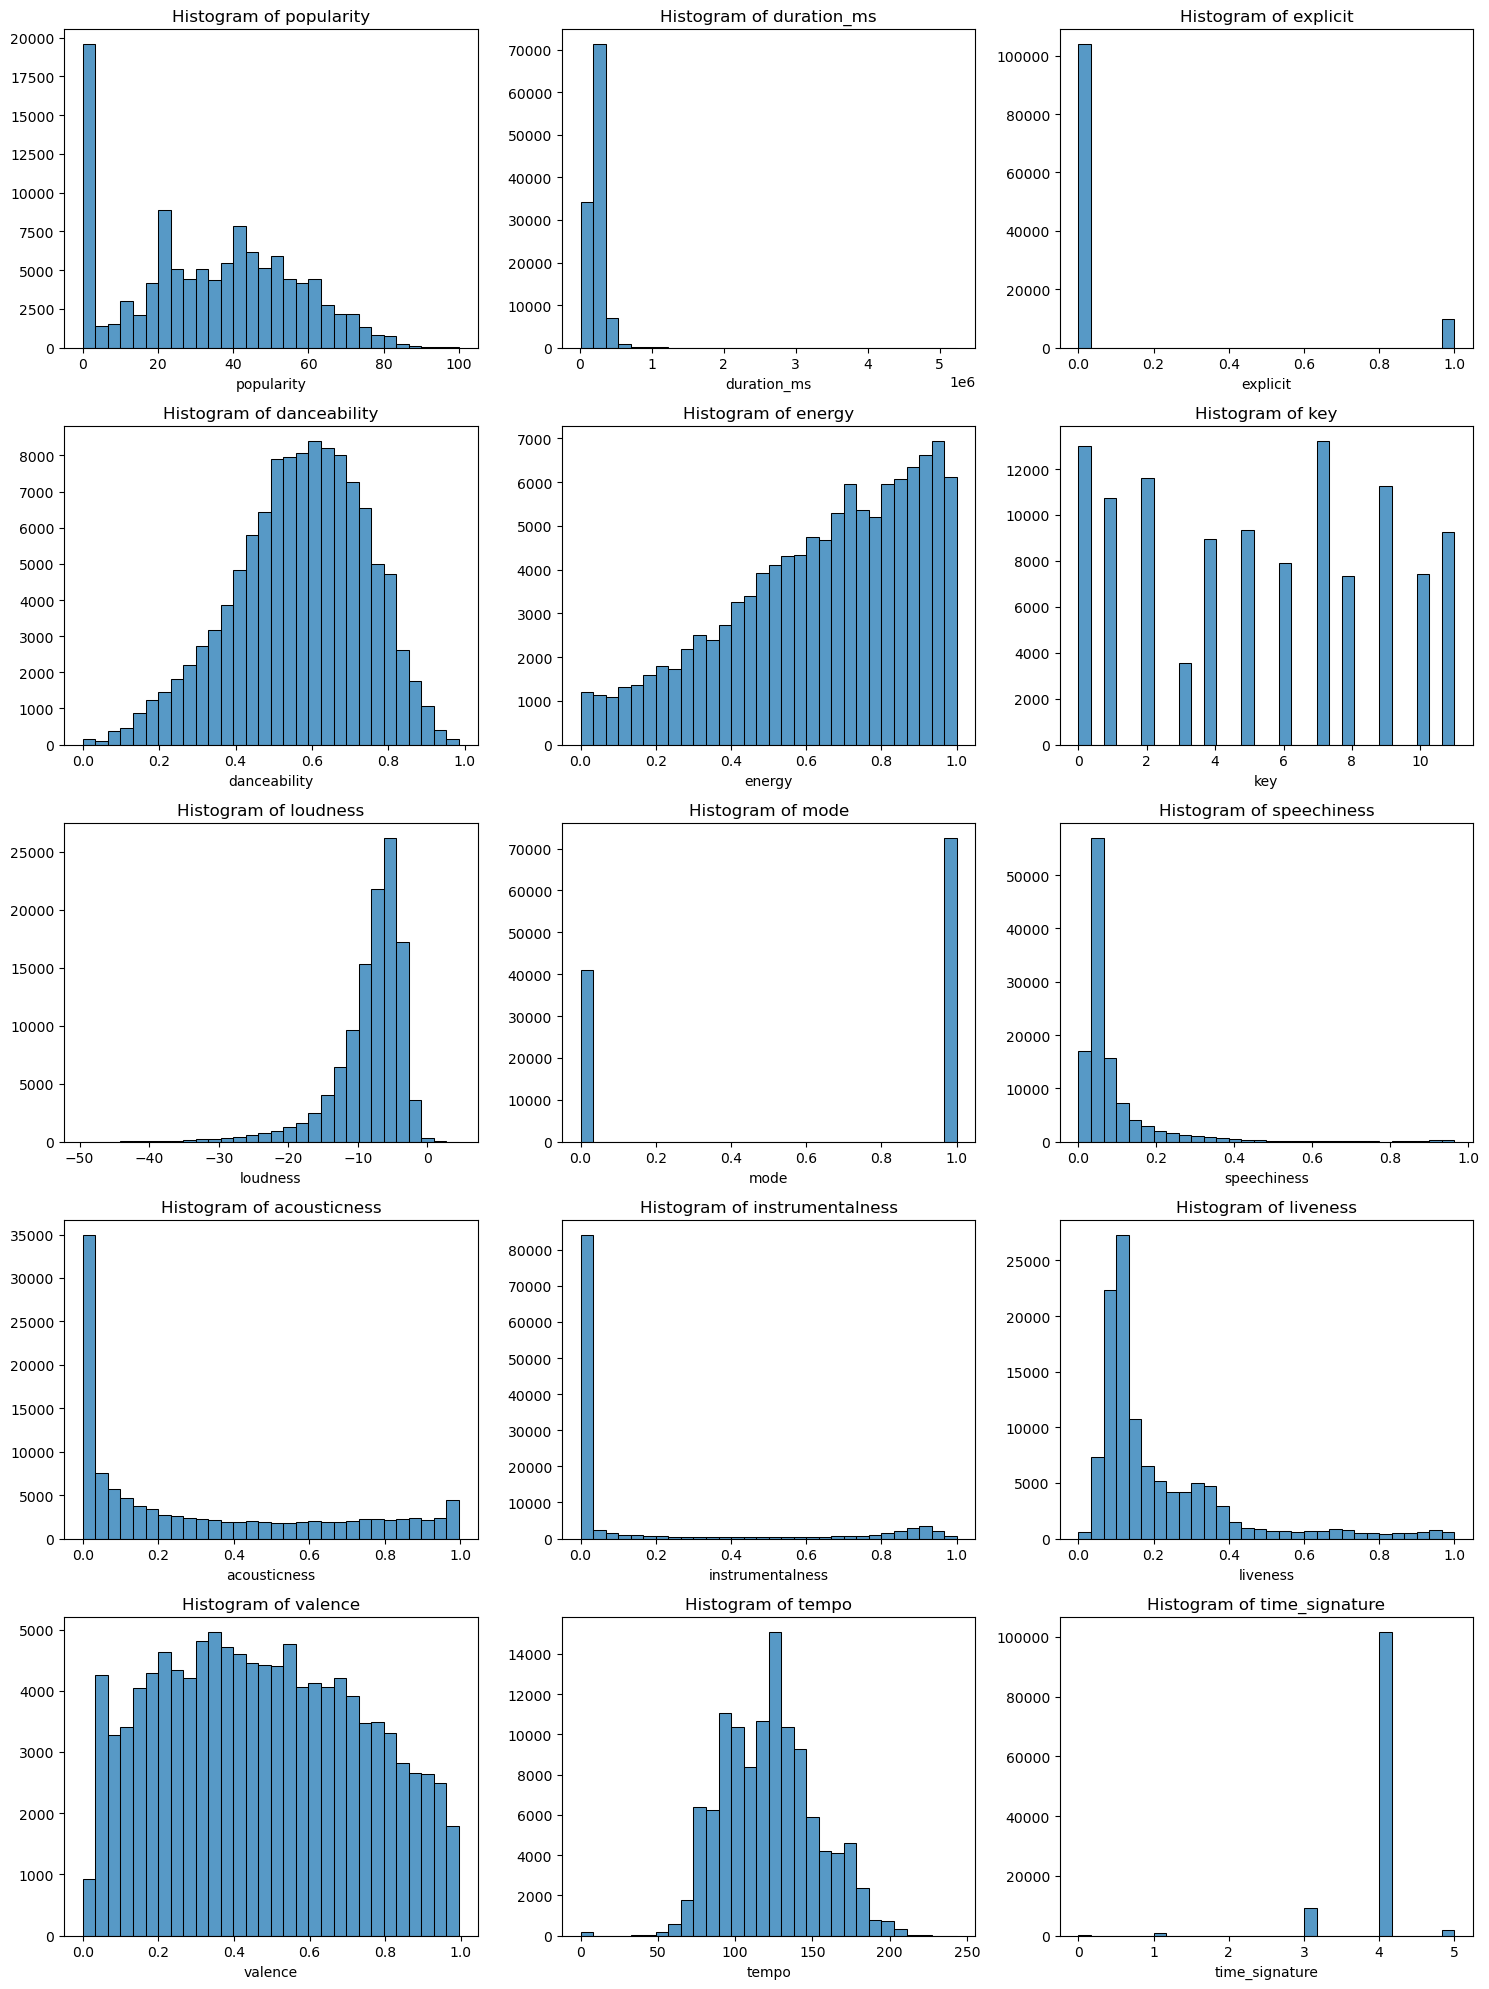

In [17]:
num_columns = num_df.columns

num_plots_per_row = 3
num_rows = math.ceil(num_df.shape[1] / num_plots_per_row)
fig, axes = plt.subplots(nrows=num_rows, ncols=num_plots_per_row, figsize=(15, 4 * num_rows))
axes = axes.flatten()

for i, column in enumerate(num_columns):
    sns.histplot(num_df[column], kde=False, ax=axes[i], bins=30)
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

**Feature correlation**

In [18]:
correlation_matrix = num_df.corr()
correlation_matrix

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
popularity,1.000000,-0.007928,0.043938,0.034407,-0.002447,-0.004167,0.047368,-0.015009,-0.045463,-0.022356,-0.094718,-0.005668,-0.041097,0.012187,0.030567
duration_ms,-0.007928,1.000000,-0.066005,-0.074117,0.058160,0.008519,-0.004233,-0.035961,-0.063194,-0.103676,0.125301,0.010199,-0.154795,0.024312,0.018351
explicit,0.043938,-0.066005,1.000000,0.122179,0.096256,0.004843,0.107988,-0.037387,0.307455,-0.093748,-0.103169,0.032367,-0.003779,-0.003097,0.038234
danceability,0.034407,-0.074117,0.122179,1.000000,0.131694,0.036546,0.256559,-0.069783,0.108236,-0.169181,-0.183974,-0.131651,0.476755,-0.051517,0.207370
energy,-0.002447,0.058160,0.096256,0.131694,1.000000,0.048047,0.760624,-0.079331,0.141976,-0.732747,-0.179967,0.184810,0.258451,0.247361,0.186671
key,-0.004167,0.008519,0.004843,0.036546,0.048047,1.000000,0.038359,-0.135871,0.020820,-0.041124,-0.006819,-0.001518,0.034233,0.010903,0.015122
loudness,0.047368,-0.004233,0.107988,0.256559,0.760624,0.038359,1.000000,-0.042074,0.060088,-0.588111,-0.432109,0.076792,0.279428,0.212181,0.191648
mode,-0.015009,-0.035961,-0.037387,-0.069783,-0.079331,-0.135871,-0.042074,1.000000,-0.046773,0.096548,-0.050787,0.013900,0.021411,0.000371,-0.024365
speechiness,-0.045463,-0.063194,0.307455,0.108236,0.141976,0.020820,0.060088,-0.046773,1.000000,-0.001378,-0.089214,0.205092,0.036393,0.017167,-0.000397
acousticness,-0.022356,-0.103676,-0.093748,-0.169181,-0.732747,-0.041124,-0.588111,0.096548,-0.001378,1.000000,0.102134,-0.020313,-0.106240,-0.207620,-0.175621


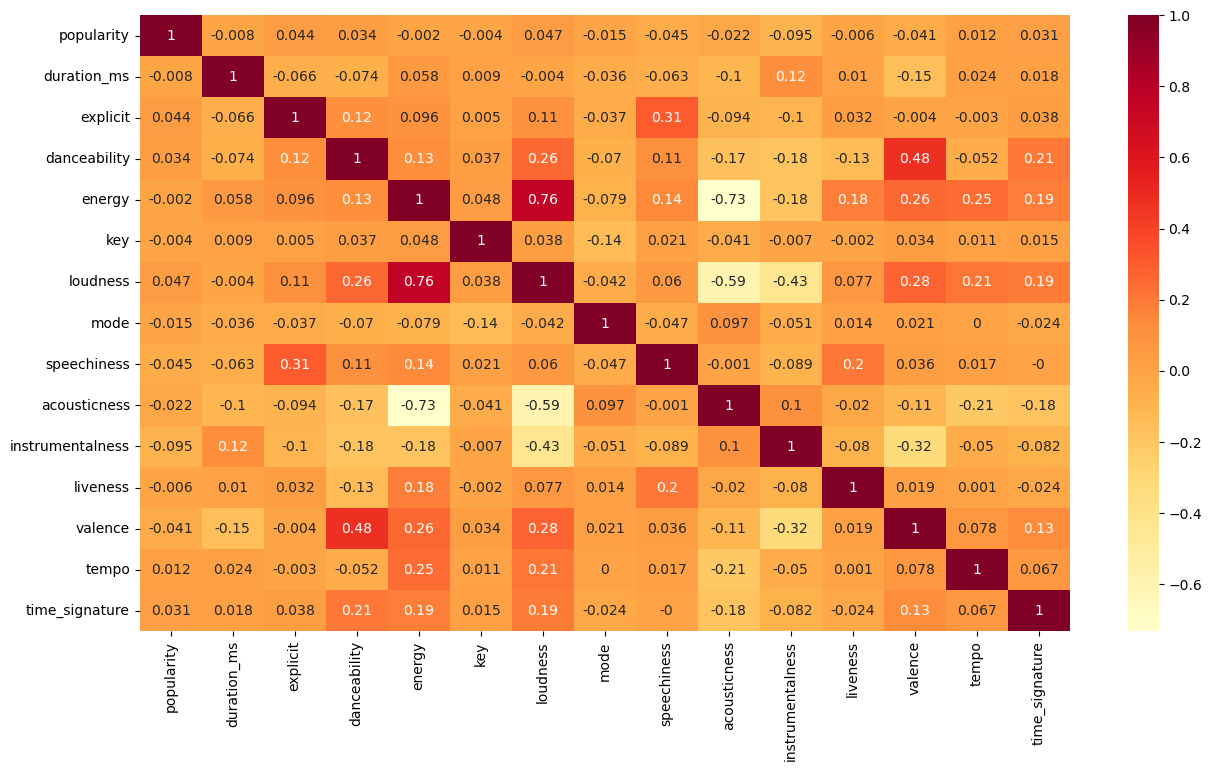

In [19]:
plt.figure(figsize=(15, 8))

sns.heatmap(correlation_matrix.round(3), cmap='YlOrRd', annot=True)
plt.show()

**Outliers detection**

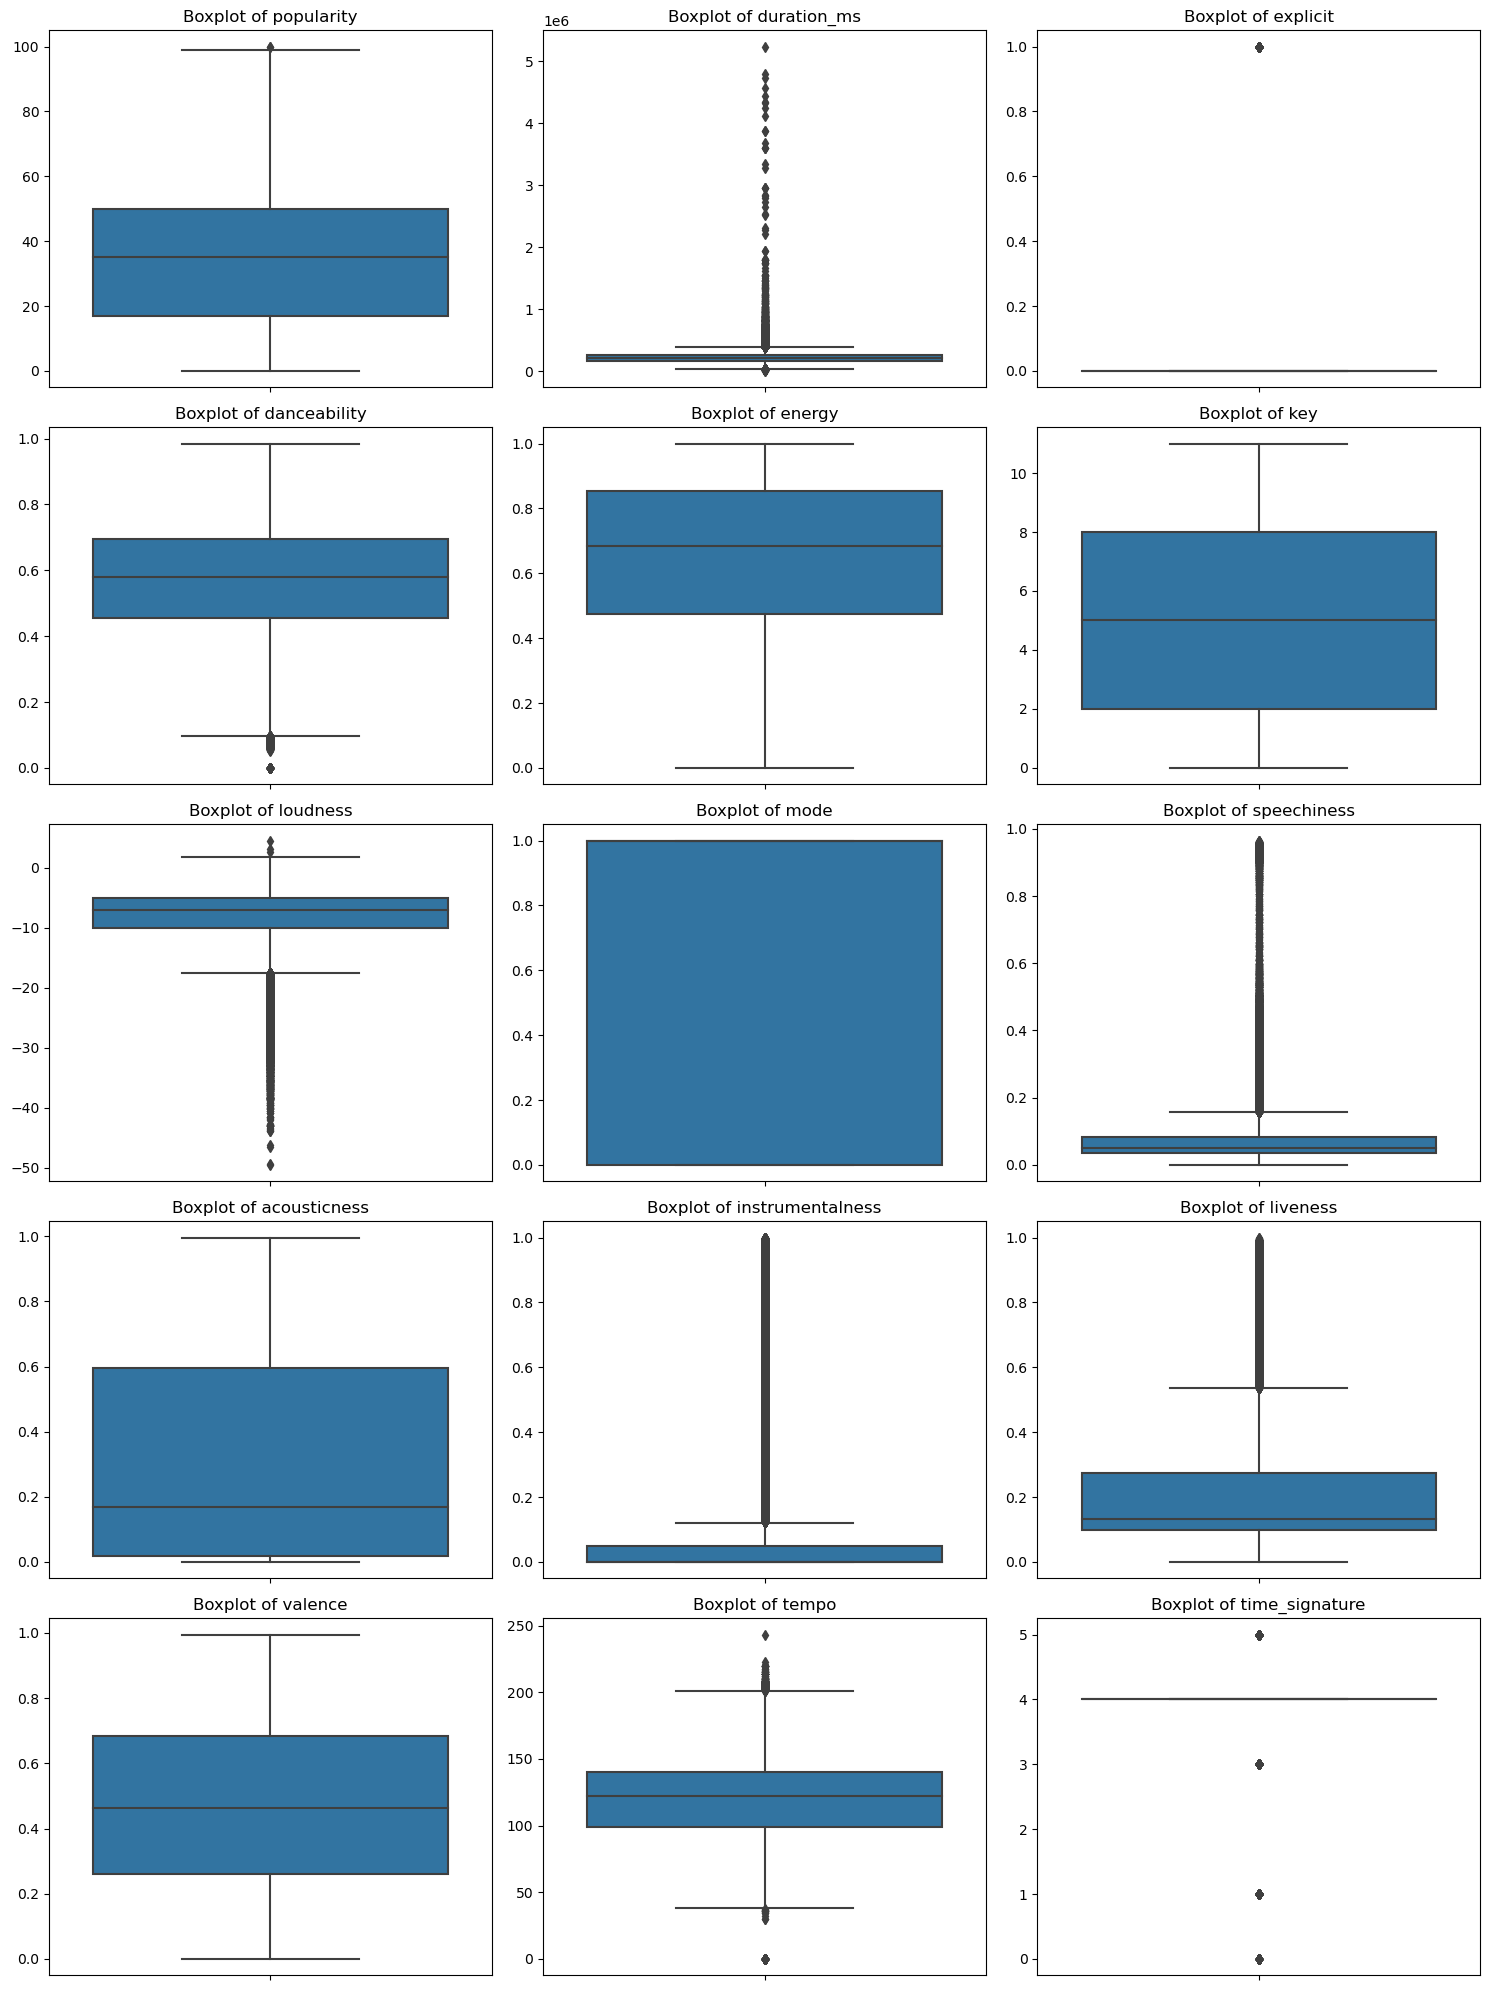

In [20]:
fig, axes = plt.subplots(nrows=num_rows, ncols=num_plots_per_row, figsize=(15, 4 * num_rows))
axes = axes.flatten()

for i, column in enumerate(num_columns):
    sns.boxplot(y=num_columns[i], data=num_df, ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

### Categorical variables analysis

In [21]:
cat_df.describe(include=['object'])

,artists,album_name,track_name,track_genre
count,113549,113549,113549,113549
unique,31437,46589,73608,114
top,The Beatles,Alternative Christmas 2022,Run Rudolph Run,acoustic
freq,279,195,151,1000


# Feature engineering

**Find the optimal values for the TargetEncoder hyperparameter smoothing**

In [22]:
def find_best_smoothing(smoothing_values,
                        param_to_encode,
                        kf = KFold(n_splits=5, shuffle=True, random_state=100)):
    smooth_tuning_df = spotify_df.copy()
    smooth_tuning_df = smooth_tuning_df.assign(artists=smooth_tuning_df['artists'].str.split(';')).explode('artists')

    X_smooth = smooth_tuning_df.drop(['track_id', 'album_name', 'popularity'], axis=1)
    y_smooth = smooth_tuning_df['popularity']
    
    columns_to_encode = ['track_name', 'artists', 'track_genre']
    columns_to_encode.remove(param_to_encode)
    X_smooth.drop(columns_to_encode, axis=1, inplace=True)
    
    best_smooth = defaultdict(lambda: [])
    
    for train_index, val_index in kf.split(X_smooth):
        X_train, X_val = X_smooth.iloc[train_index,:], X_smooth.iloc[val_index,:]
        y_train, y_val = y_smooth.iloc[train_index] , y_smooth.iloc[val_index]

        for smooth in smoothing_values:
            encoder = TargetEncoder(smoothing=smooth)
            X_train_enc_column = encoder.fit_transform(X_train[param_to_encode], y_train)
            X_val_enc_column = encoder.transform(X_val[param_to_encode])

            X_train_encoded = X_train.copy()
            X_train_encoded[param_to_encode] = X_train_enc_column

            X_val_encoded = X_val.copy()
            X_val_encoded[param_to_encode] = X_val_enc_column

            train_scaler = MinMaxScaler()
            X_train_enc_sc = train_scaler.fit_transform(X_train_encoded)
            X_train_enc_sc = pd.DataFrame(X_train_enc_sc, index=X_train_encoded.index, columns=X_train_encoded.columns)

            val_scaler = MinMaxScaler()
            X_val_enc_sc = val_scaler.fit_transform(X_val_encoded)
            X_val_enc_sc = pd.DataFrame(X_val_enc_sc, index=X_val_encoded.index, columns=X_val_encoded.columns)

            regressor = RidgeRegNormalEquation()
            regressor.fit(X_train_enc_sc, y_train)
            predictions = regressor.predict(X_val_enc_sc)

            error = mean_squared_error(y_val, predictions)

            best_smooth[smooth].append(error)
    
    error_averages = {key: sum(values) / len(values) for key, values in best_smooth.items()}
    return error_averages, min(error_averages, key=error_averages.get)

In [23]:
track_smooth_errors, track_smooth = find_best_smoothing([100, 125, 150, 175, 200], 'track_name')
print({key: round(value, 5) for key, value in track_smooth_errors.items()})
print((f'\nBest smoothing value for track_name target encoding is {track_smooth}'))

{100: 208.71823, 125: 208.43883, 150: 208.34488, 175: 208.32343, 200: 208.33235}

Best smoothing value for track_name target encoding is 175


In [24]:
artists_smooth_errors, artists_smooth = find_best_smoothing([75, 80, 85, 90, 95], 'artists')
print({key: round(value, 5) for key, value in artists_smooth_errors.items()})
print((f'\nBest smoothing value for artists target encoding is {artists_smooth}'))

{75: 265.55109, 80: 264.84455, 85: 264.40164, 90: 264.43284, 95: 265.01604}

Best smoothing value for artists target encoding is 85


In [25]:
genre_smooth_errors, genre_smooth = find_best_smoothing([0.0001, 1, 5, 50, 1000], 'track_genre')
print({key: round(value, 5) for key, value in genre_smooth_errors.items()})
print((f'\nThere is no need of smoothing for track_genre target encoding'))

{0.0001: 380.18306, 1: 380.18306, 5: 380.18306, 50: 380.18306, 1000: 380.83029}

There is no need of smoothing for track_genre target encoding


**Add feature num_genres (the number of genres per track)**

In [26]:
spotify = spotify_df.copy()

In [27]:
spotify['num_genres'] = spotify.groupby('track_id')['track_genre'].transform('nunique')

**Add feature genre_encoded (track_genre target encoding)** 

In [28]:
genre_encoder = TargetEncoder()
spotify['genre_encoded'] = genre_encoder.fit_transform(spotify['track_genre'], spotify['popularity'])

- Drop track_genre column
- Group tracks by id aggregating the genre_encoded average value

In [29]:
spotify.drop('track_genre', axis=1, inplace=True)

In [30]:
spotify_grouped = spotify.groupby('track_id').agg({'genre_encoded': 'mean'})
spotify_grouped.reset_index(inplace=True)
spotify = pd.merge(spotify.drop('genre_encoded', axis=1).drop_duplicates(), spotify_grouped, on='track_id', how='inner')

**Add feature num_artists (the number of artistis per track)**

In [31]:
spotify = spotify.assign(artists=spotify['artists'].str.split(';')).explode('artists')

In [32]:
spotify['num_artists'] = spotify.groupby('track_id')['artists'].transform('nunique')

**Add feature artists_freq (artist/artists frequency encoding)**

In [33]:
artists_frequency = spotify['artists'].value_counts().reset_index()
artists_frequency = artists_frequency.rename(columns={'index': 'artists', 'artists': 'artists_freq'})

In [34]:
spotify = pd.merge(spotify, artists_frequency, on='artists', how='inner')

**Add feature album_freq (album_name frequency encoding)**

In [35]:
album_frequency = spotify['album_name'].value_counts().reset_index()
album_frequency = album_frequency.rename(columns={'index': 'album_name', 'album_name': 'album_freq'})

In [36]:
spotify = pd.merge(spotify, album_frequency, on='album_name', how='inner')

- Drop album_name column

In [37]:
spotify.drop('album_name', axis=1, inplace=True)

**Add feature artists_encoded (artists target encoding)**

In [38]:
artists_encoder = TargetEncoder()
spotify['artists_encoded'] = artists_encoder.fit_transform(spotify['artists'], spotify['popularity'])

In [39]:
spotify_smoothed = spotify.copy()
artists_en_sm = TargetEncoder(smoothing=artists_smooth)
spotify_smoothed['artists_encoded'] = artists_en_sm.fit_transform(spotify_smoothed['artists'], spotify_smoothed['popularity'])

- Drop artisits column
- Group tracks by id aggregating the artists_freq and artists_encoded average values

In [40]:
spotify.drop('artists', axis=1, inplace=True)

spotify_grouped = spotify.groupby('track_id').agg({'artists_freq': 'mean', 'artists_encoded': 'mean'})
spotify_grouped.reset_index(inplace=True)
spotify = pd.merge(spotify.drop(['artists_freq', 'artists_encoded'], axis=1).drop_duplicates(), spotify_grouped, on='track_id', how='inner')

In [41]:
spotify_smoothed.drop('artists', axis=1, inplace=True)

spotify_group = spotify_smoothed.groupby('track_id').agg({'artists_freq': 'mean', 'artists_encoded': 'mean'})
spotify_group.reset_index(inplace=True)
spotify_smoothed = pd.merge(spotify_smoothed.drop(['artists_freq', 'artists_encoded'], axis=1).drop_duplicates(), spotify_group, on='track_id', how='inner')

**Add feature track_encoded (track_name target encoding)**

In [42]:
track_encoder = TargetEncoder()
spotify['track_encoded'] = track_encoder.fit_transform(spotify['track_name'], spotify['popularity'])

In [43]:
track_en_sm = TargetEncoder(smoothing=track_smooth)
spotify_smoothed['track_encoded'] = track_en_sm.fit_transform(spotify_smoothed['track_name'], spotify_smoothed['popularity'])

- Drop track_name column

In [44]:
spotify.drop('track_name', axis=1, inplace=True)
spotify_smoothed.drop('track_name', axis=1, inplace=True)

- Drop track_id column

In [45]:
spotify.drop('track_id', axis=1, inplace=True)
spotify_smoothed.drop('track_id', axis=1, inplace=True)

# Data preprocessing

**Feature correlation after categorical features encoding**

In [46]:
corr_matrix_cat = spotify.corr()
corr_matrix_cat

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,time_signature,num_genres,genre_encoded,num_artists,album_freq,artists_freq,artists_encoded,track_encoded
popularity,1.000000,-0.023294,0.054815,0.063941,0.012713,0.002559,0.070865,-0.016242,-0.047412,-0.037833,...,-0.011897,0.006504,0.036904,0.011399,0.571030,0.017228,-0.329641,-0.058601,0.680859,0.763331
duration_ms,-0.023294,1.000000,-0.065623,-0.064028,0.063048,0.011341,0.000035,-0.039535,-0.061148,-0.108395,...,-0.147420,0.026029,0.022530,-0.017878,-0.037351,0.027498,-0.087844,-0.041932,0.016250,0.027647
explicit,0.054815,-0.065623,1.000000,0.119008,0.099798,0.006788,0.108752,-0.034107,0.327314,-0.090686,...,-0.003003,-0.003969,0.037001,-0.002455,0.040162,0.031221,-0.024524,-0.055149,0.051000,0.046226
danceability,0.063941,-0.064028,0.119008,1.000000,0.143036,0.035131,0.271006,-0.062452,0.109405,-0.176679,...,0.491251,-0.022430,0.209644,0.056031,0.067629,0.041960,-0.053051,-0.024075,0.033725,0.037785
energy,0.012713,0.063048,0.099798,0.143036,1.000000,0.046298,0.758547,-0.074854,0.140645,-0.732379,...,0.256280,0.258584,0.186471,0.058233,0.031826,-0.045223,-0.135299,-0.087048,0.075417,0.038813
key,0.002559,0.011341,0.006788,0.035131,0.046298,1.000000,0.035705,-0.142141,0.017534,-0.044876,...,0.026105,0.008405,0.014896,0.014655,0.004884,0.007582,-0.015892,-0.011839,0.001521,0.004424
loudness,0.070865,0.000035,0.108752,0.271006,0.758547,0.035705,1.000000,-0.037165,0.055153,-0.582464,...,0.288744,0.228579,0.193545,0.095319,0.108713,-0.027501,-0.131136,-0.048582,0.120708,0.044484
mode,-0.016242,-0.039535,-0.034107,-0.062452,-0.074854,-0.142141,-0.037165,1.000000,-0.040629,0.090756,...,0.025443,-0.001976,-0.023860,0.002358,0.007237,-0.034888,0.038806,0.056130,-0.018249,-0.037584
speechiness,-0.047412,-0.061148,0.327314,0.109405,0.140645,0.017534,0.055153,-0.040629,1.000000,0.005275,...,0.033294,0.004073,-0.006116,-0.046371,-0.072982,0.032205,-0.028092,-0.060032,-0.030339,-0.015840
acousticness,-0.037833,-0.108395,-0.090686,-0.176679,-0.732379,-0.044876,-0.582464,0.090756,0.005275,1.000000,...,-0.103799,-0.220809,-0.174117,-0.081803,-0.040907,0.030644,0.118557,0.087879,-0.079616,-0.065225


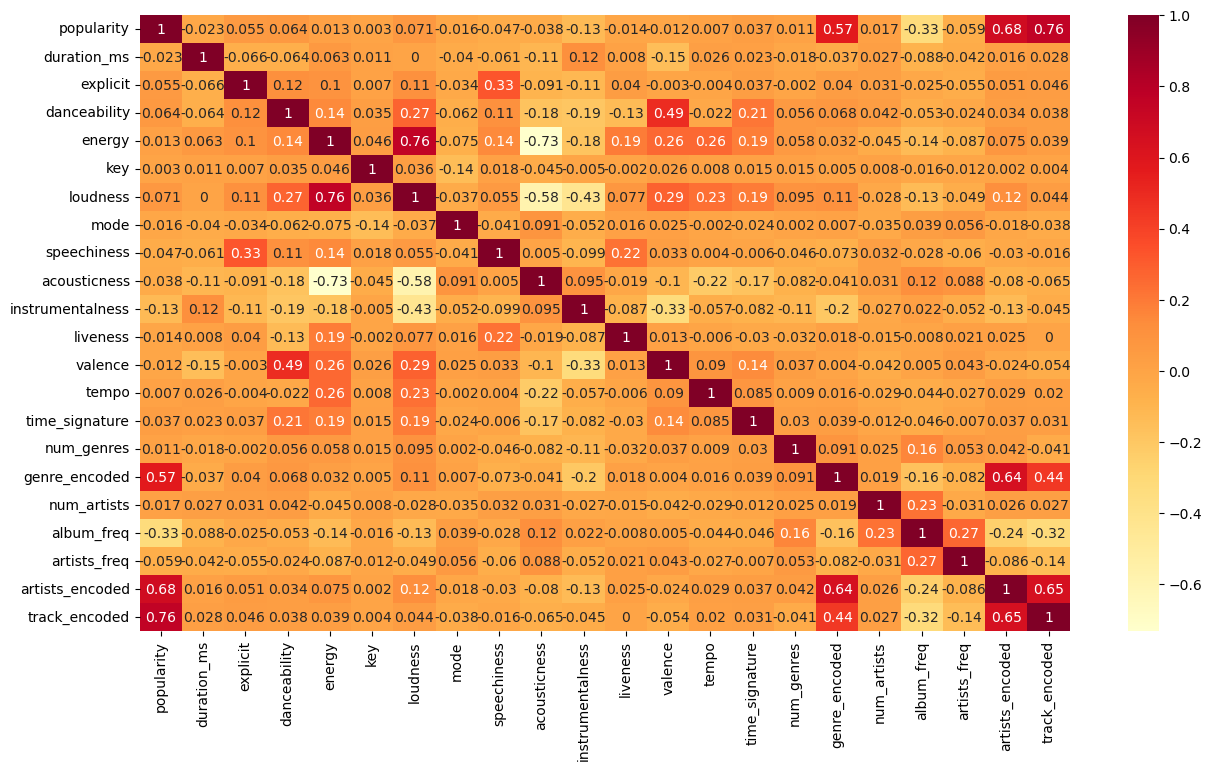

In [47]:
plt.figure(figsize=(15, 8))

sns.heatmap(corr_matrix_cat.round(3), cmap='YlOrRd', annot=True)
plt.show()

In [48]:
corr_matrix_cat_sm = spotify_smoothed.corr()
corr_matrix_cat_sm

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,time_signature,num_genres,genre_encoded,num_artists,album_freq,artists_freq,artists_encoded,track_encoded
popularity,1.000000,-0.023294,0.054815,0.063941,0.012713,0.002559,0.070865,-0.016242,-0.047412,-0.037833,...,-0.011897,0.006504,0.036904,0.011399,0.571030,0.017228,-0.329641,-0.058601,0.814047,0.917087
duration_ms,-0.023294,1.000000,-0.065623,-0.064028,0.063048,0.011341,0.000035,-0.039535,-0.061148,-0.108395,...,-0.147420,0.026029,0.022530,-0.017878,-0.037351,0.027498,-0.087844,-0.041932,-0.010956,-0.018176
explicit,0.054815,-0.065623,1.000000,0.119008,0.099798,0.006788,0.108752,-0.034107,0.327314,-0.090686,...,-0.003003,-0.003969,0.037001,-0.002455,0.040162,0.031221,-0.024524,-0.055149,0.056647,0.055798
danceability,0.063941,-0.064028,0.119008,1.000000,0.143036,0.035131,0.271006,-0.062452,0.109405,-0.176679,...,0.491251,-0.022430,0.209644,0.056031,0.067629,0.041960,-0.053051,-0.024075,0.069878,0.067551
energy,0.012713,0.063048,0.099798,0.143036,1.000000,0.046298,0.758547,-0.074854,0.140645,-0.732379,...,0.256280,0.258584,0.186471,0.058233,0.031826,-0.045223,-0.135299,-0.087048,0.042303,0.018612
key,0.002559,0.011341,0.006788,0.035131,0.046298,1.000000,0.035705,-0.142141,0.017534,-0.044876,...,0.026105,0.008405,0.014896,0.014655,0.004884,0.007582,-0.015892,-0.011839,0.002084,0.003446
loudness,0.070865,0.000035,0.108752,0.271006,0.758547,0.035705,1.000000,-0.037165,0.055153,-0.582464,...,0.288744,0.228579,0.193545,0.095319,0.108713,-0.027501,-0.131136,-0.048582,0.107806,0.076398
mode,-0.016242,-0.039535,-0.034107,-0.062452,-0.074854,-0.142141,-0.037165,1.000000,-0.040629,0.090756,...,0.025443,-0.001976,-0.023860,0.002358,0.007237,-0.034888,0.038806,0.056130,-0.020000,-0.019559
speechiness,-0.047412,-0.061148,0.327314,0.109405,0.140645,0.017534,0.055153,-0.040629,1.000000,0.005275,...,0.033294,0.004073,-0.006116,-0.046371,-0.072982,0.032205,-0.028092,-0.060032,-0.048433,-0.046559
acousticness,-0.037833,-0.108395,-0.090686,-0.176679,-0.732379,-0.044876,-0.582464,0.090756,0.005275,1.000000,...,-0.103799,-0.220809,-0.174117,-0.081803,-0.040907,0.030644,0.118557,0.087879,-0.064286,-0.043396


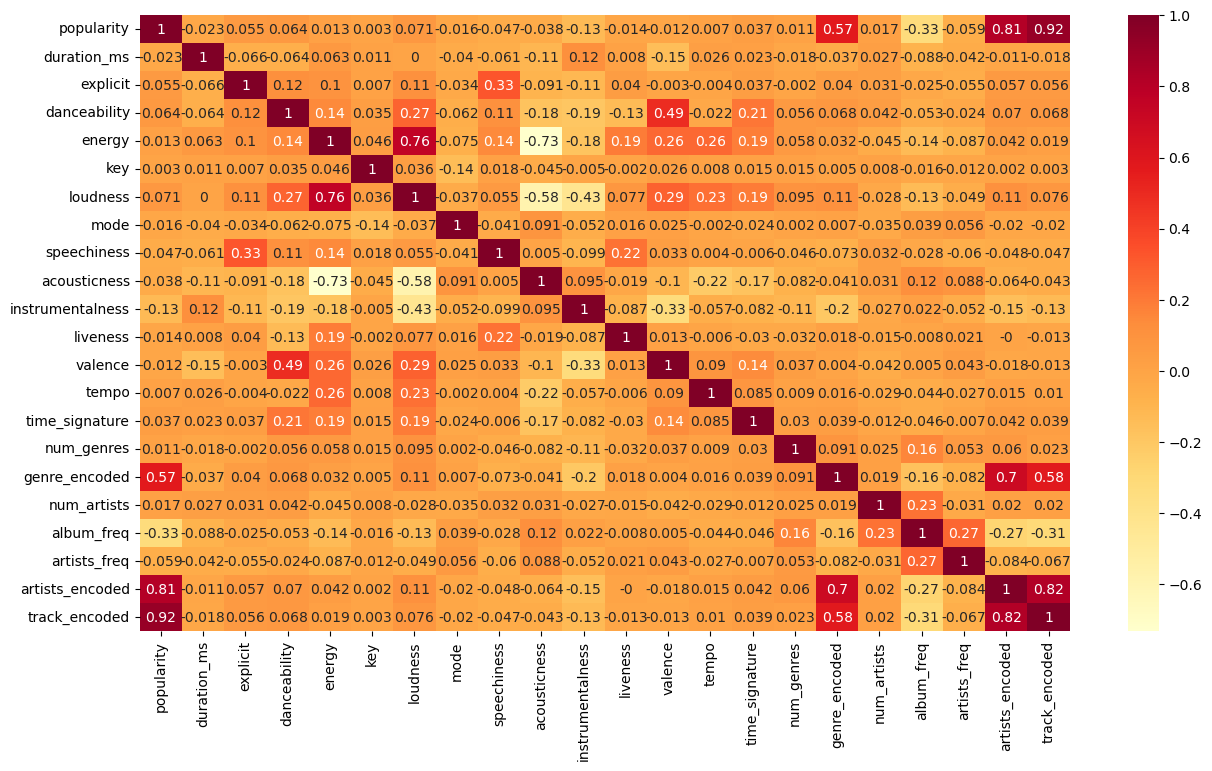

In [49]:
plt.figure(figsize=(15, 8))

sns.heatmap(corr_matrix_cat_sm.round(3), cmap='YlOrRd', annot=True)
plt.show()

In [50]:
X = spotify.drop('popularity', axis=1)
y = spotify['popularity']

X_smoothed = spotify_smoothed.drop('popularity', axis=1)
y_smoothed = spotify_smoothed['popularity']

In [51]:
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

scaler_sm = MinMaxScaler()
X_smoothed = pd.DataFrame(scaler_sm.fit_transform(X_smoothed), index=X_smoothed.index, columns=X_smoothed.columns)

# Models execution

In [54]:
def executeRidgeRegModel(X, y, model_type,
                         alphas=np.logspace(-3, 2, num=6)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, shuffle=True)
    
    rmse_train = []
    rmse_test = []
    r2_train = []
    r2_test = []

    for alpha in alphas:
        if model_type == 'NE':
            ridge_reg = RidgeRegNormalEquation(alpha=alpha)
        elif model_type == 'SGD':
            ridge_reg = RidgeRegGradientDescent(alpha=alpha)
        else:
            raise ValueError('Parameter model_type value must be NE or SGD')
        
        ridge_reg.fit(X_train, y_train)

        y_pred_train = ridge_reg.predict(X_train)
        y_pred_test = ridge_reg.predict(X_test)

        rmse_train_ = mean_squared_error(y_train, y_pred_train, squared=False)
        rmse_test_ = mean_squared_error(y_test, y_pred_test, squared=False)

        r2_train_ = r2_score(y_train, y_pred_train)
        r2_test_ = r2_score(y_test, y_pred_test)

        rmse_train.append(rmse_train_)
        rmse_test.append(rmse_test_)
        r2_train.append(r2_train_)
        r2_test.append(r2_test_)

    best_alpha_index = rmse_test.index(min(rmse_test))

    best_rmse_train = rmse_train[best_alpha_index]
    best_rmse_test = rmse_test[best_alpha_index]
    best_r2_train = r2_train[best_alpha_index]
    best_r2_test = r2_test[best_alpha_index]
    best_alpha = alphas[best_alpha_index]

    print('Best alpha:', best_alpha)
    print('Best train RMSE:', best_rmse_train)
    print('Best test RMSE:', best_rmse_test)
    print('Best train R-squared:', best_r2_train)
    print('Best test R-squared:', best_r2_test)

    plt.plot(alphas, rmse_train, label='Train error')
    plt.plot(alphas, rmse_test, label='Test error')
    plt.xscale('log')
    plt.xlabel('Alpha')
    plt.ylabel('RMSE')
    plt.title('RMSE vs Alpha')
    plt.legend()
    plt.show()

In [55]:
def executeRidgeRegModelCV(X, y,
                           alphas=np.logspace(-3, 2, num=6)):
    kf = KFold(n_splits=5, shuffle=True, random_state=100)
    
    rmse_train = []
    rmse_test = []
    r2_train = []
    r2_test = []
    weights = defaultdict(lambda: [])
    
    for alpha in alphas:  
        fold_rmse_train = []
        fold_rmse_test = []
        fold_r2_train = []
        fold_r2_test = []
        fold_weights = []
        
        for train_index, val_index in kf.split(X):
            X_train, X_val = X.iloc[train_index,:], X.iloc[val_index,:]
            y_train, y_val = y.iloc[train_index] , y.iloc[val_index]

            ridge_reg = RidgeRegNormalEquation(alpha=alpha)
        
            ridge_reg.fit(X_train, y_train)

            y_pred_train = ridge_reg.predict(X_train)
            y_pred_val = ridge_reg.predict(X_val)

            rmse_train_ = mean_squared_error(y_train, y_pred_train, squared=False)
            rmse_test_ = mean_squared_error(y_val, y_pred_val, squared=False)

            r2_train_ = r2_score(y_train, y_pred_train)
            r2_test_ = r2_score(y_val, y_pred_val)
            
            fold_rmse_train.append(rmse_train_)
            fold_rmse_test.append(rmse_test_)
            fold_r2_train.append(r2_train_)
            fold_r2_test.append(r2_test_)
            fold_weights.append(ridge_reg.w)

        avg_rmse_train = np.mean(fold_rmse_train)
        avg_rmse_test = np.mean(fold_rmse_test)
        avg_r2_train = np.mean(fold_r2_train)
        avg_r2_test = np.mean(fold_r2_test)
        
        rmse_train.append(avg_rmse_train)
        rmse_test.append(avg_rmse_test)
        r2_train.append(avg_r2_train)
        r2_test.append(avg_r2_test)
        weights[alpha].append(fold_weights)

    best_alpha_index = rmse_test.index(min(rmse_test))

    best_rmse_train = rmse_train[best_alpha_index]
    best_rmse_test = rmse_test[best_alpha_index]
    best_r2_train = r2_train[best_alpha_index]
    best_r2_test = r2_test[best_alpha_index]
    best_alpha = alphas[best_alpha_index]
    
    best_weights = np.mean(weights[best_alpha], axis=1)[0] 

    print('Best alpha:', best_alpha)
    print('Best train RMSE:', best_rmse_train)
    print('Best test RMSE:', best_rmse_test)
    print('Best train R-squared:', best_r2_train)
    print('Best test R-squared:', best_r2_test)

    plt.plot(alphas, rmse_train, label='Train error')
    plt.plot(alphas, rmse_test, label='Test error')
    plt.xscale('log')
    plt.xlabel('Alpha')
    plt.ylabel('RMSE')
    plt.title('RMSE vs Alpha')
    plt.legend()
    plt.show()
    
    print('\nIntercept value:', best_weights[0])
    sns.barplot(x=np.mean(weights[1.0], axis=1)[0][1:], y=X.columns, palette='viridis')
    plt.title('Model features weights')
    plt.show()

### Numerical features only

In [56]:
num_columns = num_df.columns.tolist()
num_columns.remove('popularity')

X_num = X[num_columns]

**No cross-validation**

Best alpha: 0.001
Best train RMSE: 20.22679186185301
Best test RMSE: 20.32822420826373
Best train R-squared: 0.03377882654327791
Best test R-squared: 0.03352447468407749


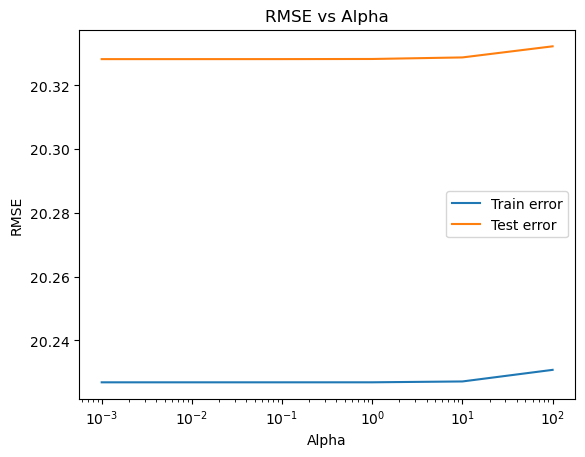

In [57]:
executeRidgeRegModel(X_num, y, model_type='NE')

Best alpha: 0.001
Best train RMSE: 20.380379113464375
Best test RMSE: 20.512012027403745
Best train R-squared: 0.019049583031048756
Best test R-squared: 0.01596963182148814


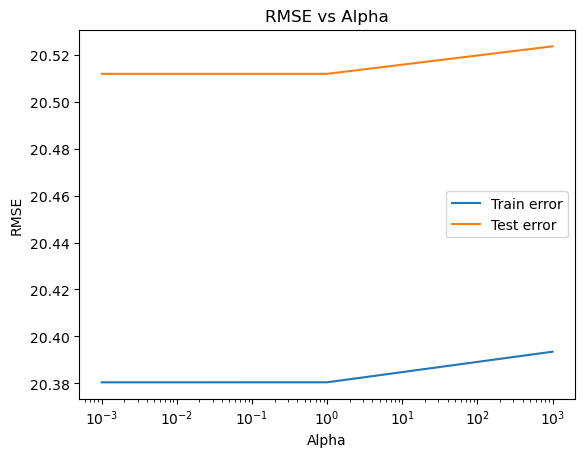

In [56]:
executeRidgeRegModel(X_num, y, model_type='SGD', alphas=np.logspace(-3, 3, num=3))

**5-fold cross-validation**

Best alpha: 1.0
Best train RMSE: 20.255885257940424
Best test RMSE: 20.259784401457416
Best train R-squared: 0.03383966582306155
Best test R-squared: 0.033396388046014636


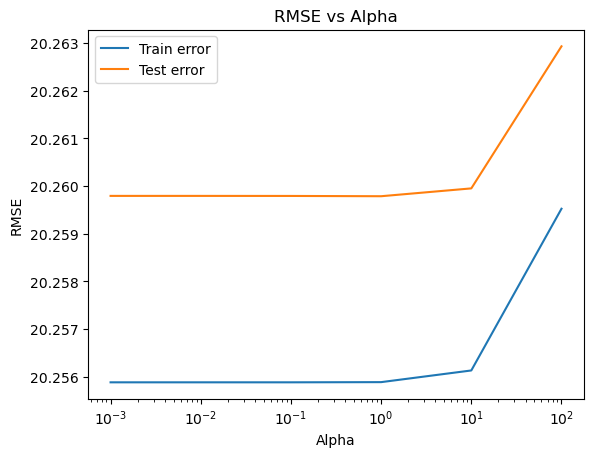


Intercept value: 30.06306900159675


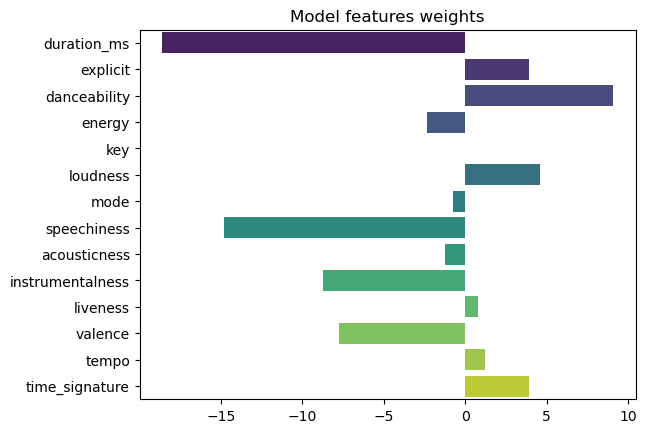

In [58]:
executeRidgeRegModelCV(X_num, y)

### Numerical and categorical features (not smoothed target encoding)

**No cross-validation**

Best alpha: 0.001
Best train RMSE: 11.580477265411302
Best test RMSE: 11.552989082182886
Best train R-squared: 0.6832800239817377
Best test R-squared: 0.6878375200546945


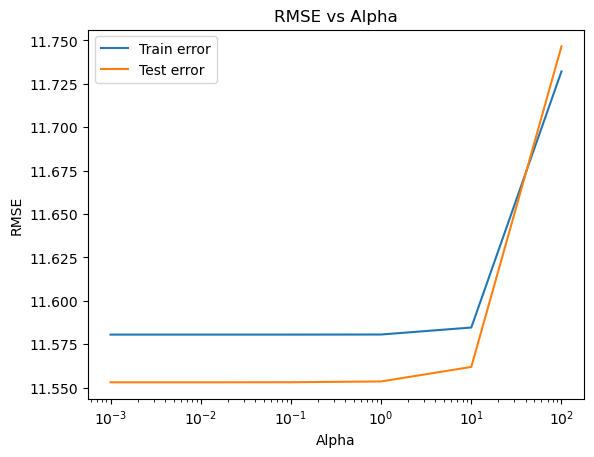

In [59]:
executeRidgeRegModel(X, y, model_type='NE')

Best alpha: 0.001
Best train RMSE: 15.004232664894225
Best test RMSE: 15.105378574527204
Best train R-squared: 0.46832025066763316
Best test R-squared: 0.46635160854470337


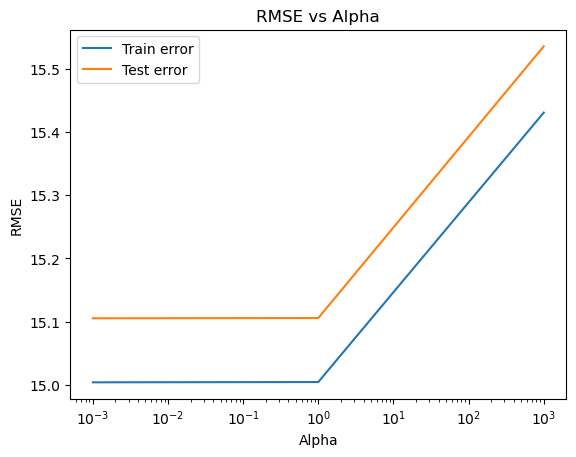

In [59]:
executeRidgeRegModel(X, y, model_type='SGD', alphas=np.logspace(-3, 3, num=3))

**5-fold cross-validation**

Best alpha: 0.1
Best train RMSE: 11.570330140771734
Best test RMSE: 11.576858086689066
Best train R-squared: 0.6847593878727019
Best test R-squared: 0.6843378403899923


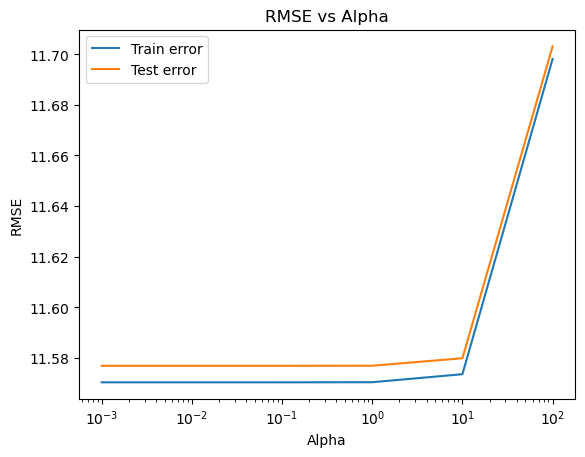


Intercept value: -80.1617234471012


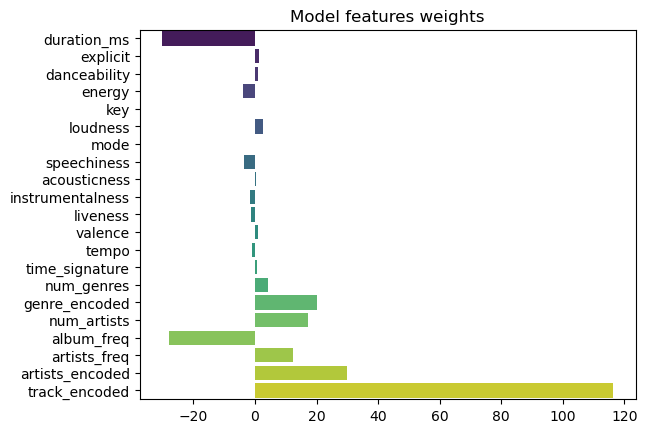

In [61]:
executeRidgeRegModelCV(X, y)

### Numerical and categorical features (smoothed target encoding)

**No cross-validation**

Best alpha: 1.0
Best train RMSE: 7.820833615895012
Best test RMSE: 7.801628418152003
Best train R-squared: 0.8555463125685504
Best test R-squared: 0.8576483519255679


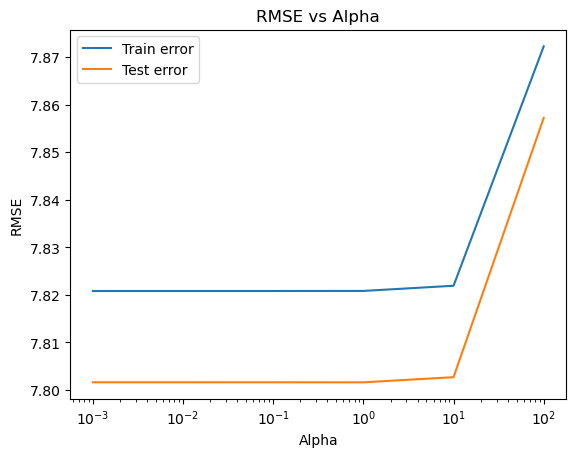

In [62]:
executeRidgeRegModel(X_smoothed, y_smoothed, model_type='NE')

Best alpha: 0.001
Best train RMSE: 10.408376844913032
Best test RMSE: 10.451750369584689
Best train R-squared: 0.7441481538925827
Best test R-squared: 0.744512278411637


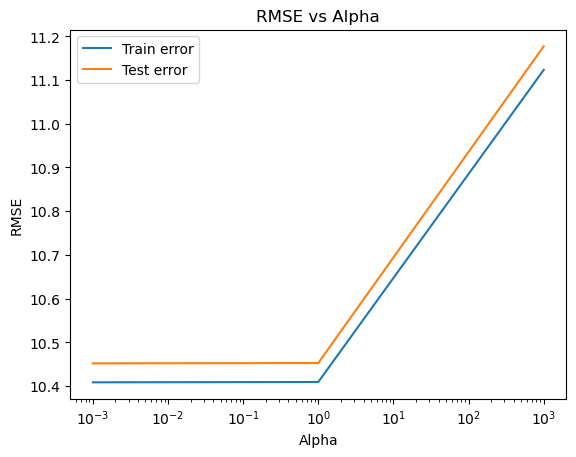

In [62]:
executeRidgeRegModel(X_smoothed, y_smoothed, model_type='SGD', alphas=np.logspace(-3, 3, num=3))

**5-fold cross-validation**

Best alpha: 0.1
Best train RMSE: 7.8145729999782745
Best test RMSE: 7.816011276104693
Best train R-squared: 0.8561983870172323
Best test R-squared: 0.8561025860476995


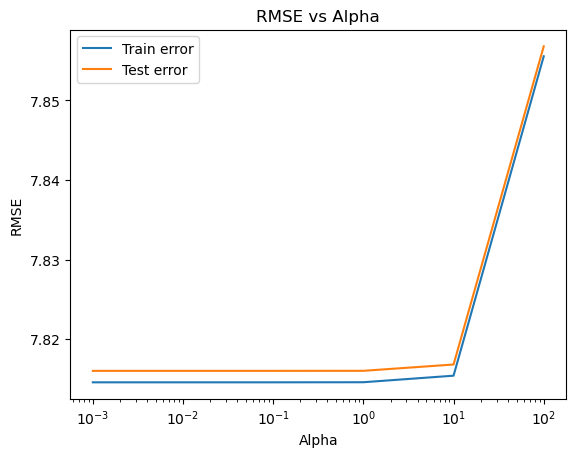


Intercept value: -5.138275040801186


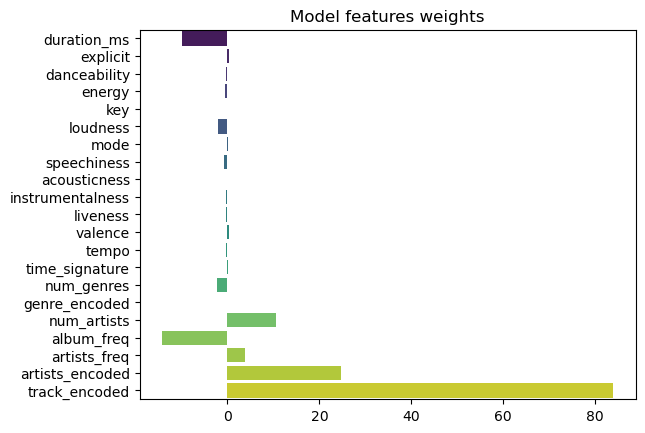

In [63]:
executeRidgeRegModelCV(X_smoothed, y_smoothed)

### Numerical and categorical features without track_encoded field (smoothed target encoding)

In [65]:
X_smoothed_no_track = X_smoothed.drop('track_encoded', axis=1)

**5-fold cross-validation**

Best alpha: 0.1
Best train RMSE: 11.650864416881088
Best test RMSE: 11.65440866301199
Best train R-squared: 0.6803577636594846
Best test R-squared: 0.6801275131617643


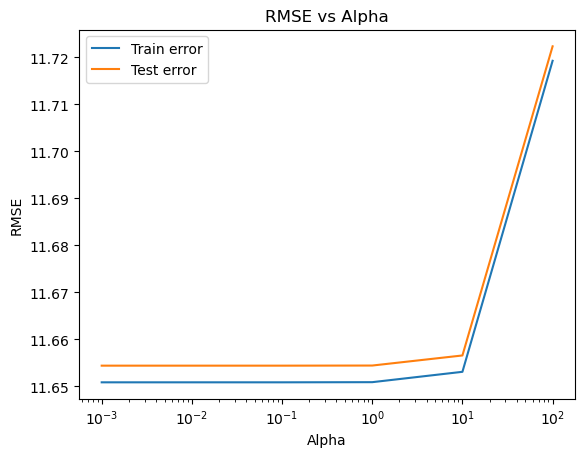


Intercept value: -6.312608621348459


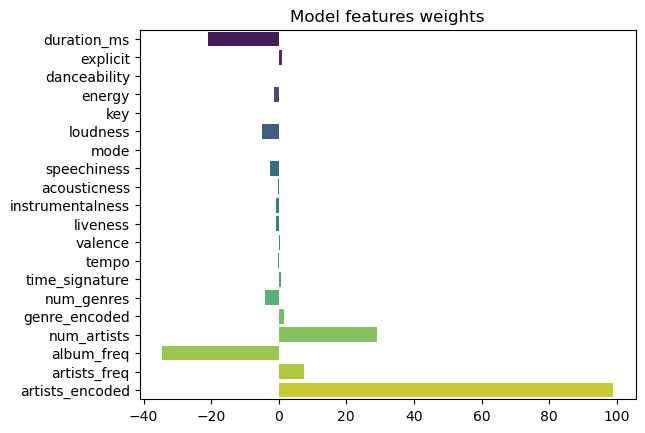

In [66]:
executeRidgeRegModelCV(X_smoothed_no_track, y_smoothed)

### Categorical features only (smoothed target encoding)

In [67]:
X_smoothed_cat = X_smoothed.drop(num_columns, axis=1)

**5-fold cross-validation**

Best alpha: 0.1
Best train RMSE: 7.8258024536277615
Best test RMSE: 7.826184828801994
Best train R-squared: 0.8557848100192272
Best test R-squared: 0.8557278183027119


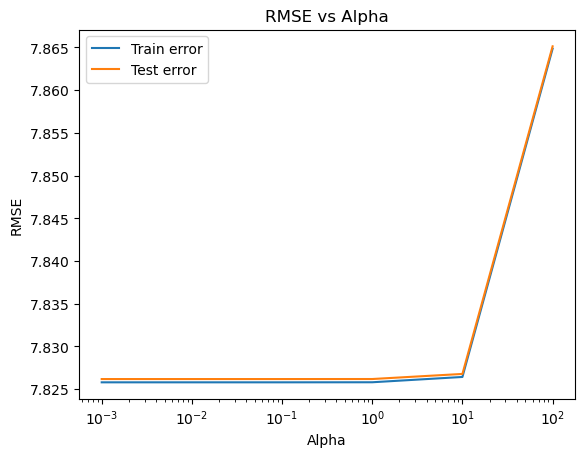


Intercept value: -7.962158322915182


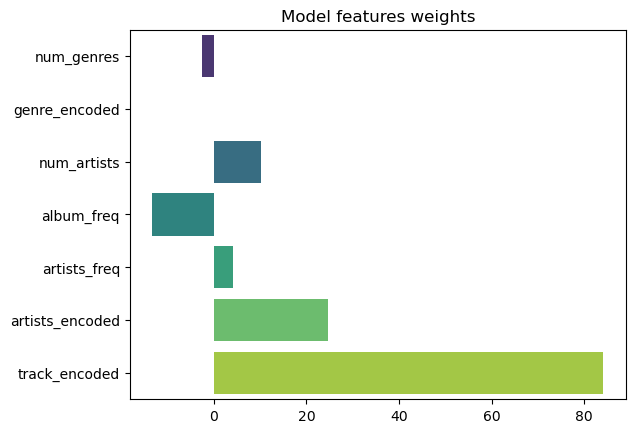

In [68]:
executeRidgeRegModelCV(X_smoothed_cat, y_smoothed)

### Categorical features and duration_ms field (smoothed target encoding)

In [69]:
num_columns = X_num.columns.tolist()
num_columns.remove('duration_ms')
X_smoothed_cat_duration = X_smoothed.drop(num_columns, axis=1)

**5-fold cross-validation**

Best alpha: 0.1
Best train RMSE: 7.821888471698443
Best test RMSE: 7.822279000910399
Best train R-squared: 0.8559290342740248
Best test R-squared: 0.8558718710405593


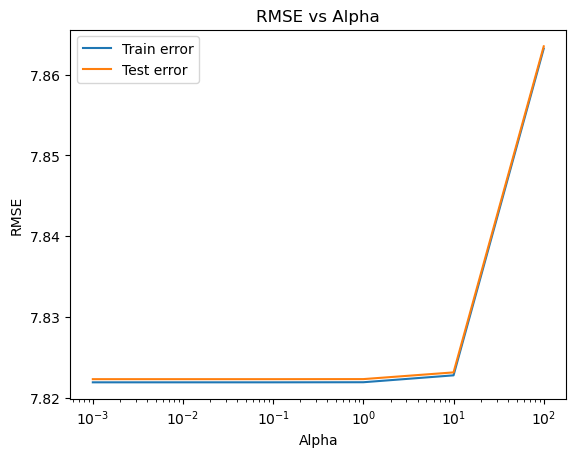


Intercept value: -7.431238965062573


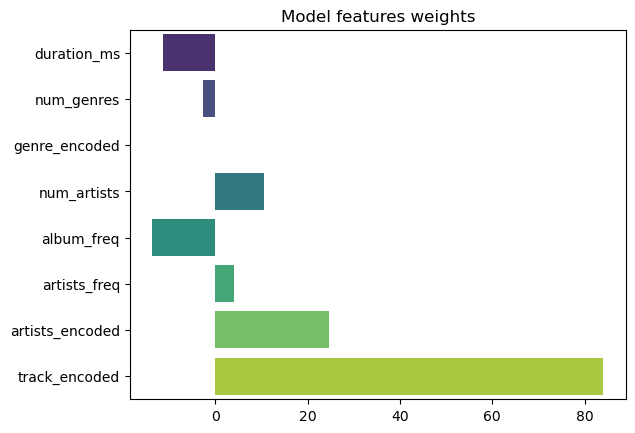

In [70]:
executeRidgeRegModelCV(X_smoothed_cat_duration, y_smoothed)